<a href="https://colab.research.google.com/github/Vibertexs/B-A-Tutorials/blob/main/Lung_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Website: https://vibertexkhan.wixsite.com/banda/post/lung-segmentation-using-u-net

In [ ]:
# Imports
import matplotlib.pyplot as plt # To visualise the plots
import os # Provides functions for interacting with the operating system.
import numpy as np # Numpy 
from pathlib import Path # To work with the paths
import tensorflow as tf # Tensorflow
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D # We'll use some of these later for our U-Net!
from sklearn.model_selection import train_test_split # Train test split
import gdown # To download the data
from ipywidgets import interact, IntSlider # Allows you to interreact  with the code to visualise better

In [ ]:
# Downloading Our data
IMG_PATH = "reduced/imgs"
MASK_PATH = "reduced/masks"
EPOCHS = 40

gdown.download("https://drive.google.com/uc?id=1_2UHVdkeuCHwwcb2RGs0cosNw8l_YoAE", "reduced.zip", True)
!unzip -oq reduced.zip

In [ ]:
# Helpful functions 

def load(): # Load in the data thats already been prepared to work with
    imgs_paths = sorted([Path(IMG_PATH) / p for p in os.listdir(IMG_PATH)])
    masks_paths = sorted([Path(MASK_PATH) / p for p in os.listdir(MASK_PATH)])
    imgs = [plt.imread(p) for p in imgs_paths]
    masks = [plt.imread(p)[:, :, 0][:, :, None] > 0.5 for p in masks_paths]
    imgs, masks = np.array(imgs)[:,:,:,0:1], np.array(masks).astype(float)
    imgs_train, imgs_test, masks_train, masks_test = train_test_split(
        imgs, masks, test_size=0.2, shuffle=False
    )
    return imgs_train, imgs_test, masks_train, masks_test

def show_lung_mask_sbs(lung, mask): # Show the lung and the mask
    fig, (a1, a2) = plt.subplots(1, 2)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")


def show_lung_mask_pred_sbs(lung, mask, pred): # Show the lung, mask, and the model output
    fig, (a1, a2, a3) = plt.subplots(1, 3)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a3.imshow(pred.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")
    a3.set_title("predicted mask")



class ShowLearning(tf.keras.callbacks.Callback): # Call back function
    def __init__(self, data, masks, name):
        self.data = data
        self.masks = masks
        self.fig_path = f"lung/figs/{name}"
        if not os.path.exists(self.fig_path):
            os.makedirs(self.fig_path)
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        rand_index = np.random.randint(0, len(self.data))
        rand_img = self.data[rand_index][None, :, :, :]
        mask = self.masks[rand_index][None, :, :, :]
        preds = self.model(rand_img).numpy() > 0.5
        show_lung_mask_pred_sbs(rand_img, mask, preds)
        plt.savefig(f"{self.fig_path}/epoch{epoch}.png")
        plt.close()

def show_training_image(name, epoch): # Used to inter
  im = plt.imread(f'lung/figs/{name}/epoch{epoch}.png')
  plt.imshow(im)

#Data Exploration

In [ ]:
imgs_train, imgs_test, masks_train, masks_test = load()
print(imgs_train.shape, imgs_test.shape, masks_train.shape, masks_test.shape)

(213, 64, 64, 1) (54, 64, 64, 1) (213, 64, 64, 1) (54, 64, 64, 1)


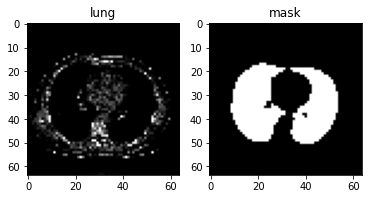

In [ ]:
img_num = 20 # Pick any image from the training set
show_lung_mask_sbs(imgs_train[img_num], masks_train[img_num])

# Convolutional Neural Networks

In [ ]:
def SimpleConvModel():
    model = tf.keras.models.Sequential(
        [
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding="same", activation="relu"),
            Conv2D(filters = 32, kernel_size = 3, strides = 1, padding="same", activation="relu"),
            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding="same", activation="relu"),
            Conv2D(filters = 1, kernel_size = 3, strides = 1, padding="same", activation="sigmoid"),
        ]
    )
    return model

model = SimpleConvModel()

In [ ]:
def train(model, imgs, masks, loss, name, epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    model.fit(imgs, masks, epochs=epochs, callbacks=[ShowLearning(imgs, masks, name)],)
    
train(model, imgs_train, masks_train, tf.losses.BinaryCrossentropy(), 'simple_conv', EPOCHS)

Epoch 1/40
7/7 [==============================] - 31s 35ms/step - loss: 0.6897 - accuracy: 0.7068
Epoch 2/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6821 - accuracy: 0.7655
Epoch 3/40
7/7 [==============================] - 0s 9ms/step - loss: 0.6704 - accuracy: 0.7652
Epoch 4/40
7/7 [==============================] - 0s 9ms/step - loss: 0.6510 - accuracy: 0.7660
Epoch 5/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6220 - accuracy: 0.7662
Epoch 6/40
7/7 [==============================] - 0s 9ms/step - loss: 0.5864 - accuracy: 0.7662
Epoch 7/40
7/7 [==============================] - 0s 10ms/step - loss: 0.5562 - accuracy: 0.7662
Epoch 8/40
7/7 [==============================] - 0s 10ms/step - loss: 0.5457 - accuracy: 0.7662
Epoch 9/40
7/7 [==============================] - 0s 9ms/step - loss: 0.5455 - accuracy: 0.7662
Epoch 10/40
7/7 [==============================] - 0s 10ms/step - loss: 0.5410 - accuracy: 0.7662
Epoch 11/40
7/7 [===============

### Predicting Model Output Size

In [ ]:
interact(lambda epoch: show_training_image('simple_conv', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [ ]:
print(masks_train.sum()/(masks_train.size)* 100)

23.375605193661972


##Dice


In [ ]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

In [ ]:
model_with_dice = SimpleConvModel()
train(model_with_dice, imgs_train, masks_train, dice_loss, 'simple_conv_with_dice', EPOCHS)

Epoch 1/40
7/7 [==============================] - 1s 12ms/step - loss: 0.6854 - accuracy: 0.3512
Epoch 2/40
7/7 [==============================] - 0s 11ms/step - loss: 0.6836 - accuracy: 0.3077
Epoch 3/40
7/7 [==============================] - 0s 12ms/step - loss: 0.6809 - accuracy: 0.3023
Epoch 4/40
7/7 [==============================] - 0s 12ms/step - loss: 0.6771 - accuracy: 0.2963
Epoch 5/40
7/7 [==============================] - 0s 11ms/step - loss: 0.6715 - accuracy: 0.2888
Epoch 6/40
7/7 [==============================] - 0s 11ms/step - loss: 0.6636 - accuracy: 0.2819
Epoch 7/40
7/7 [==============================] - 0s 11ms/step - loss: 0.6530 - accuracy: 0.2817
Epoch 8/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6398 - accuracy: 0.2929
Epoch 9/40
7/7 [==============================] - 0s 11ms/step - loss: 0.6249 - accuracy: 0.3192
Epoch 10/40
7/7 [==============================] - 0s 13ms/step - loss: 0.6097 - accuracy: 0.3584
Epoch 11/40
7/7 [============

In [ ]:
interact(lambda epoch: show_training_image('simple_conv_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [ ]:
def section(conv1_filters, conv2_filters): #Represents one horizontal "section" of the U
    return tf.keras.Sequential(
        [
            Conv2D(conv1_filters, 3, padding="same", activation="relu"),
            Conv2D(conv2_filters, 3, padding="same", activation="relu"),
        ]
    )

class U_Net(tf.keras.Model):
    def __init__(self):
        super(U_Net, self).__init__()
        self.section1 = section(16, 16)
        self.section2 = section(32, 32)
        self.section3 = section(32, 64) #Bottom of the U!
        self.section4 = section(32, 32)
        self.section5 = section(16, 16)
        self.final_conv = Conv2D(1, 3, padding="same", activation="sigmoid")
        self.maxpool1, self.maxpool2 = MaxPool2D(2), MaxPool2D(2) 
        self.upsample1, self.upsample2 = UpSampling2D(2), UpSampling2D(2)

    def call(self, inputs):
        input1 = self.section1(inputs)
        input2 = self.section2(self.maxpool1(input1))
        input3 = self.section3(self.maxpool2(input2))
        input4 = self.section4(concatenate([input2, self.upsample1(input3)]))
        input5 = self.section5(concatenate([input1, self.upsample2(input4)]))
        output = self.final_conv(input5)
        return output

In [ ]:
unet = U_Net()

In [ ]:
train(unet, imgs_train, masks_train, dice_loss, 'unet_with_dice', epochs=EPOCHS)

Epoch 1/40
7/7 [==============================] - 2s 60ms/step - loss: 0.6853 - accuracy: 0.3473
Epoch 2/40
7/7 [==============================] - 0s 20ms/step - loss: 0.6695 - accuracy: 0.2342
Epoch 3/40
7/7 [==============================] - 0s 20ms/step - loss: 0.6190 - accuracy: 0.2338
Epoch 4/40
7/7 [==============================] - 0s 20ms/step - loss: 0.6043 - accuracy: 0.2338
Epoch 5/40
7/7 [==============================] - 0s 19ms/step - loss: 0.5972 - accuracy: 0.2338
Epoch 6/40
7/7 [==============================] - 0s 20ms/step - loss: 0.5801 - accuracy: 0.2440
Epoch 7/40
7/7 [==============================] - 0s 23ms/step - loss: 0.5173 - accuracy: 0.6241
Epoch 8/40
7/7 [==============================] - 1s 22ms/step - loss: 0.4049 - accuracy: 0.8482
Epoch 9/40
7/7 [==============================] - 0s 20ms/step - loss: 0.3006 - accuracy: 0.8860
Epoch 10/40
7/7 [==============================] - 0s 20ms/step - loss: 0.2348 - accuracy: 0.9047
Epoch 11/40
7/7 [============

In [ ]:
interact(lambda epoch: show_training_image('unet_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…